<div style="text-align: center;">
    <h1>Sz correlations from MPS scaling with N</h1>
</div>


In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Statistics
using DelimitedFiles
using QuadGK

<div style="text-align: center;">
    <h3>Prepare MPS results </h3>
</div>


First, we define the parameters used from the simulations

In [2]:
mu_array = 0.0:0.1:5.0 # Array of detuning values

Nlist = [8, 10, 12, 14, 16, 20] # Number of sites in the chain

# Define parameters for the adiabatic evolution
F = 0.5 # Final value of the drive
alpha = 0.001 # Adiabatic parameter


tf = F / alpha; # Final time for the adiabatic evolution


Read data from simulations

In [3]:
num_N = length(Nlist)
num_mu = length(mu_array)

Sz_correlation2 = zeros(num_N, num_mu)

@time for (n_idx, N) in enumerate(Nlist)
    folder = "output_sudden_N=$(N),F=0.5"
    for mu_idx in 1:num_mu
        filename = joinpath(folder, "sudden_output_for_N=$(N)_mu$(mu_idx).txt")
        data = readdlm(filename)
        Sz_correlation2[n_idx, mu_idx] = data[2]
        
    end
end

  0.535255 seconds (1.08 M allocations: 68.162 MiB, 6.69% gc time, 86.47% compilation time)


<div style="text-align: center;">
    <h3>Evaluate analytical Sz correlations </h3>
</div>


First, we define functions:

In [4]:
# Function to calculate the analytical Sz correlation
function sz_corr2_analytical(μ::Real, F::Real)
    # Define the first integrand
    integrand1(k) = begin
        X = μ - 2 * cos(k)
        Y = 2 * F * sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 && Y == 0
            return 0.0 # Define the integrand value at the singularity
        end

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return - Y^2 / (X^2 + Y^2) * cos(k)
    end

    # Define the second integrand
    integrand2(k) = begin
        X = μ - 2 * cos(k)
        Y = 2 * F * sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 && Y == 0
            return 0.0 # Define the integrand value at the singularity
        end

        # This is equivalent to (Y / Sqrt[X^2+Y^2]) * Sign[X] * Sin[k]
        # Note: sin(atan(Y, X)) is equivalent to Y / sqrt(X^2 + Y^2)
        return Y * X / (X^2 + Y^2) * sin(k)
    end

    # Perform the numerical integrations using QuadGK
    # It's good practice to add rtol (relative tolerance) and atol (absolute tolerance)
    # in case the default tolerances are too loose or too strict.
    integral1, _ = quadgk(integrand1, -pi, pi, rtol=1e-8, atol=1e-8)
    integral2, _ = quadgk(integrand2, -pi, pi, rtol=1e-8, atol=1e-8)

    # Calculate the final expression
    prefactor = (1 / (2 * pi))^2
    result = prefactor * (- (integral1)^2 + (integral2)^2)

    return result
end


sz_corr2_analytical (generic function with 1 method)

Evaluate analytical data

In [5]:
# Set the value of F as required
F_val = 0.5

# Evaluate the analytical functions over the range of μ
sz_corr2_anal = [sz_corr2_analytical(μ, F_val) for μ in mu_array];

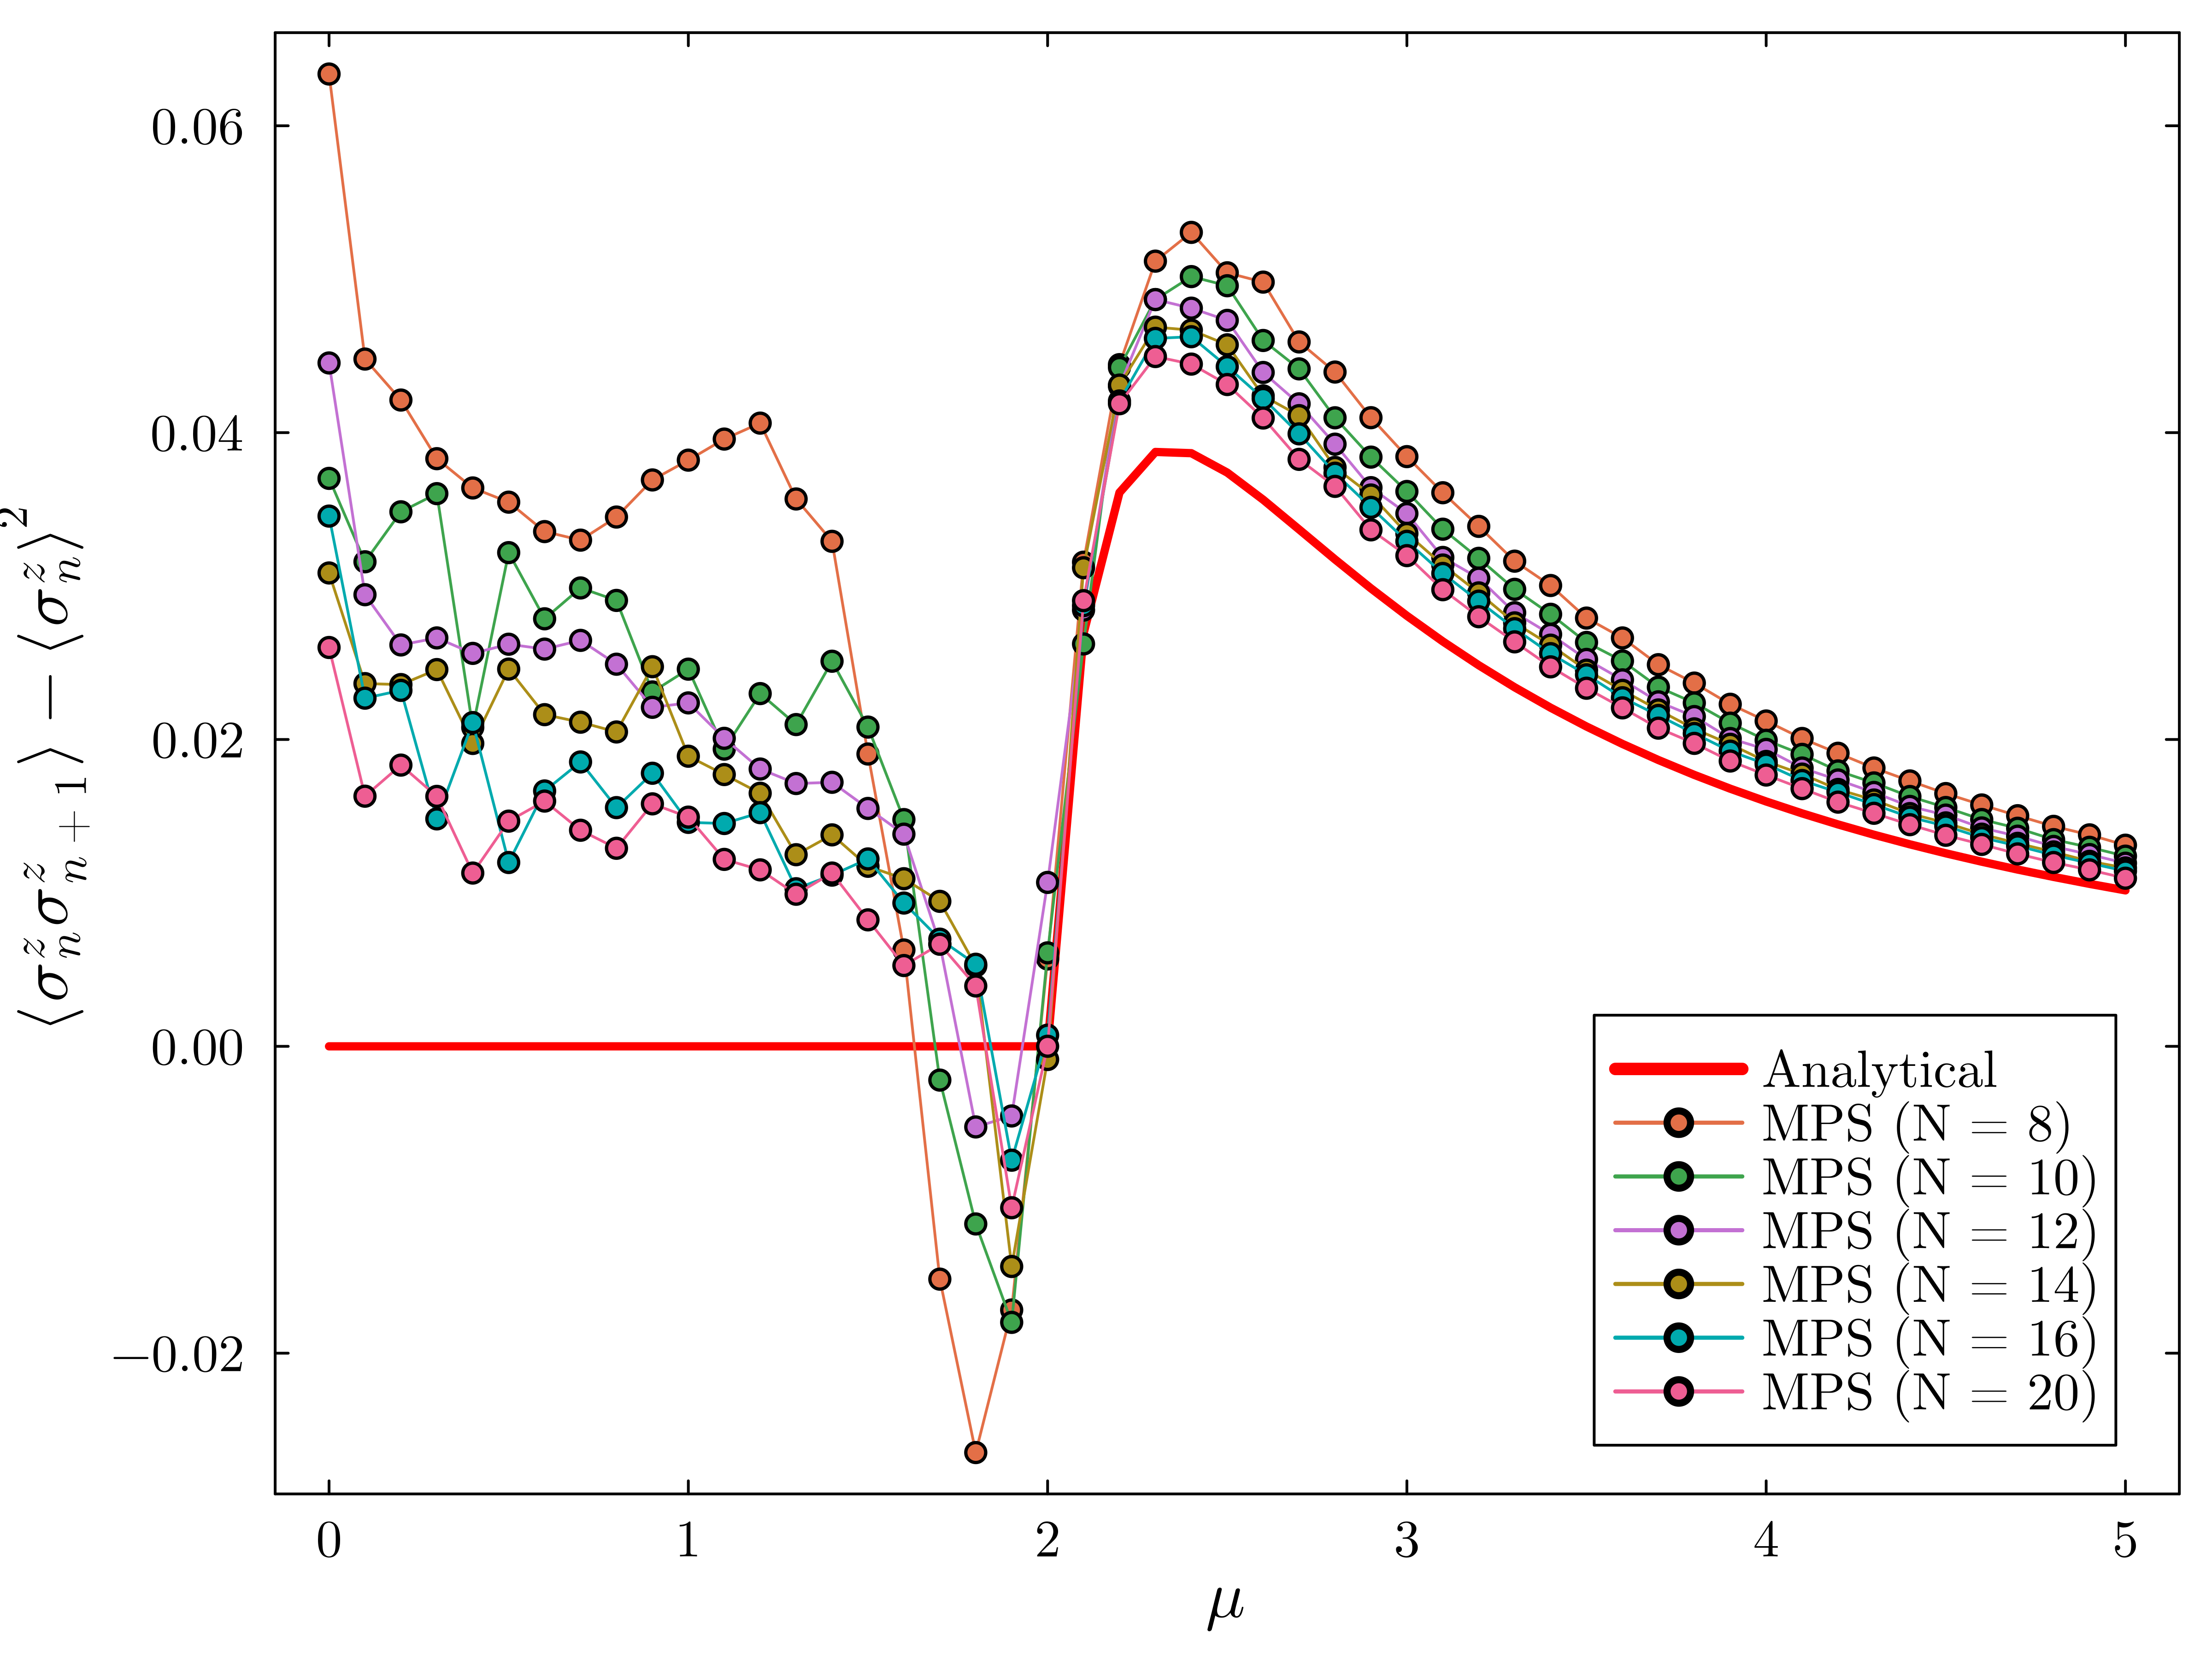

"c:\\Users\\khalafel\\OneDrive - Michigan State University\\Research\\OneDrive - Michigan State University\\Research\\Tensor network project\\sudden_spin_szcorr2.png"

In [6]:
# Plot analytical line (red, thick)
xlabel_val = L"\mu"
ylabel_val = L"\langle σ^z_n σ^z_{n+1} \rangle-\langle σ^z_n \rangle^2"

p = plot(
    mu_array,
    sz_corr2_anal,
    label = "Analytical",
    line = (:solid, 3, :red),
    xlabel = xlabel_val,
    ylabel = ylabel_val,
    legend = :bottomright, # Changed legend position
    grid = false,
    framestyle = :box,
    tickfontsize = 12,
    labelfontsize = 16,
    legendfontsize = 12,
    size = (800, 600), # Increased plot size
    dpi = 600,
    fontfamily = "Computer Modern",
)
# Plot all numerical results for each N
for (n_idx, N) in enumerate(Nlist)
    plot!(
        p,
        mu_array,
        Sz_correlation2[n_idx, :],
        marker = (:circle, 4),
        label = "MPS (N = $N)",
    )
end
# Display and save the plot
display(p)
savefig(p, "sudden_spin_szcorr2.png")

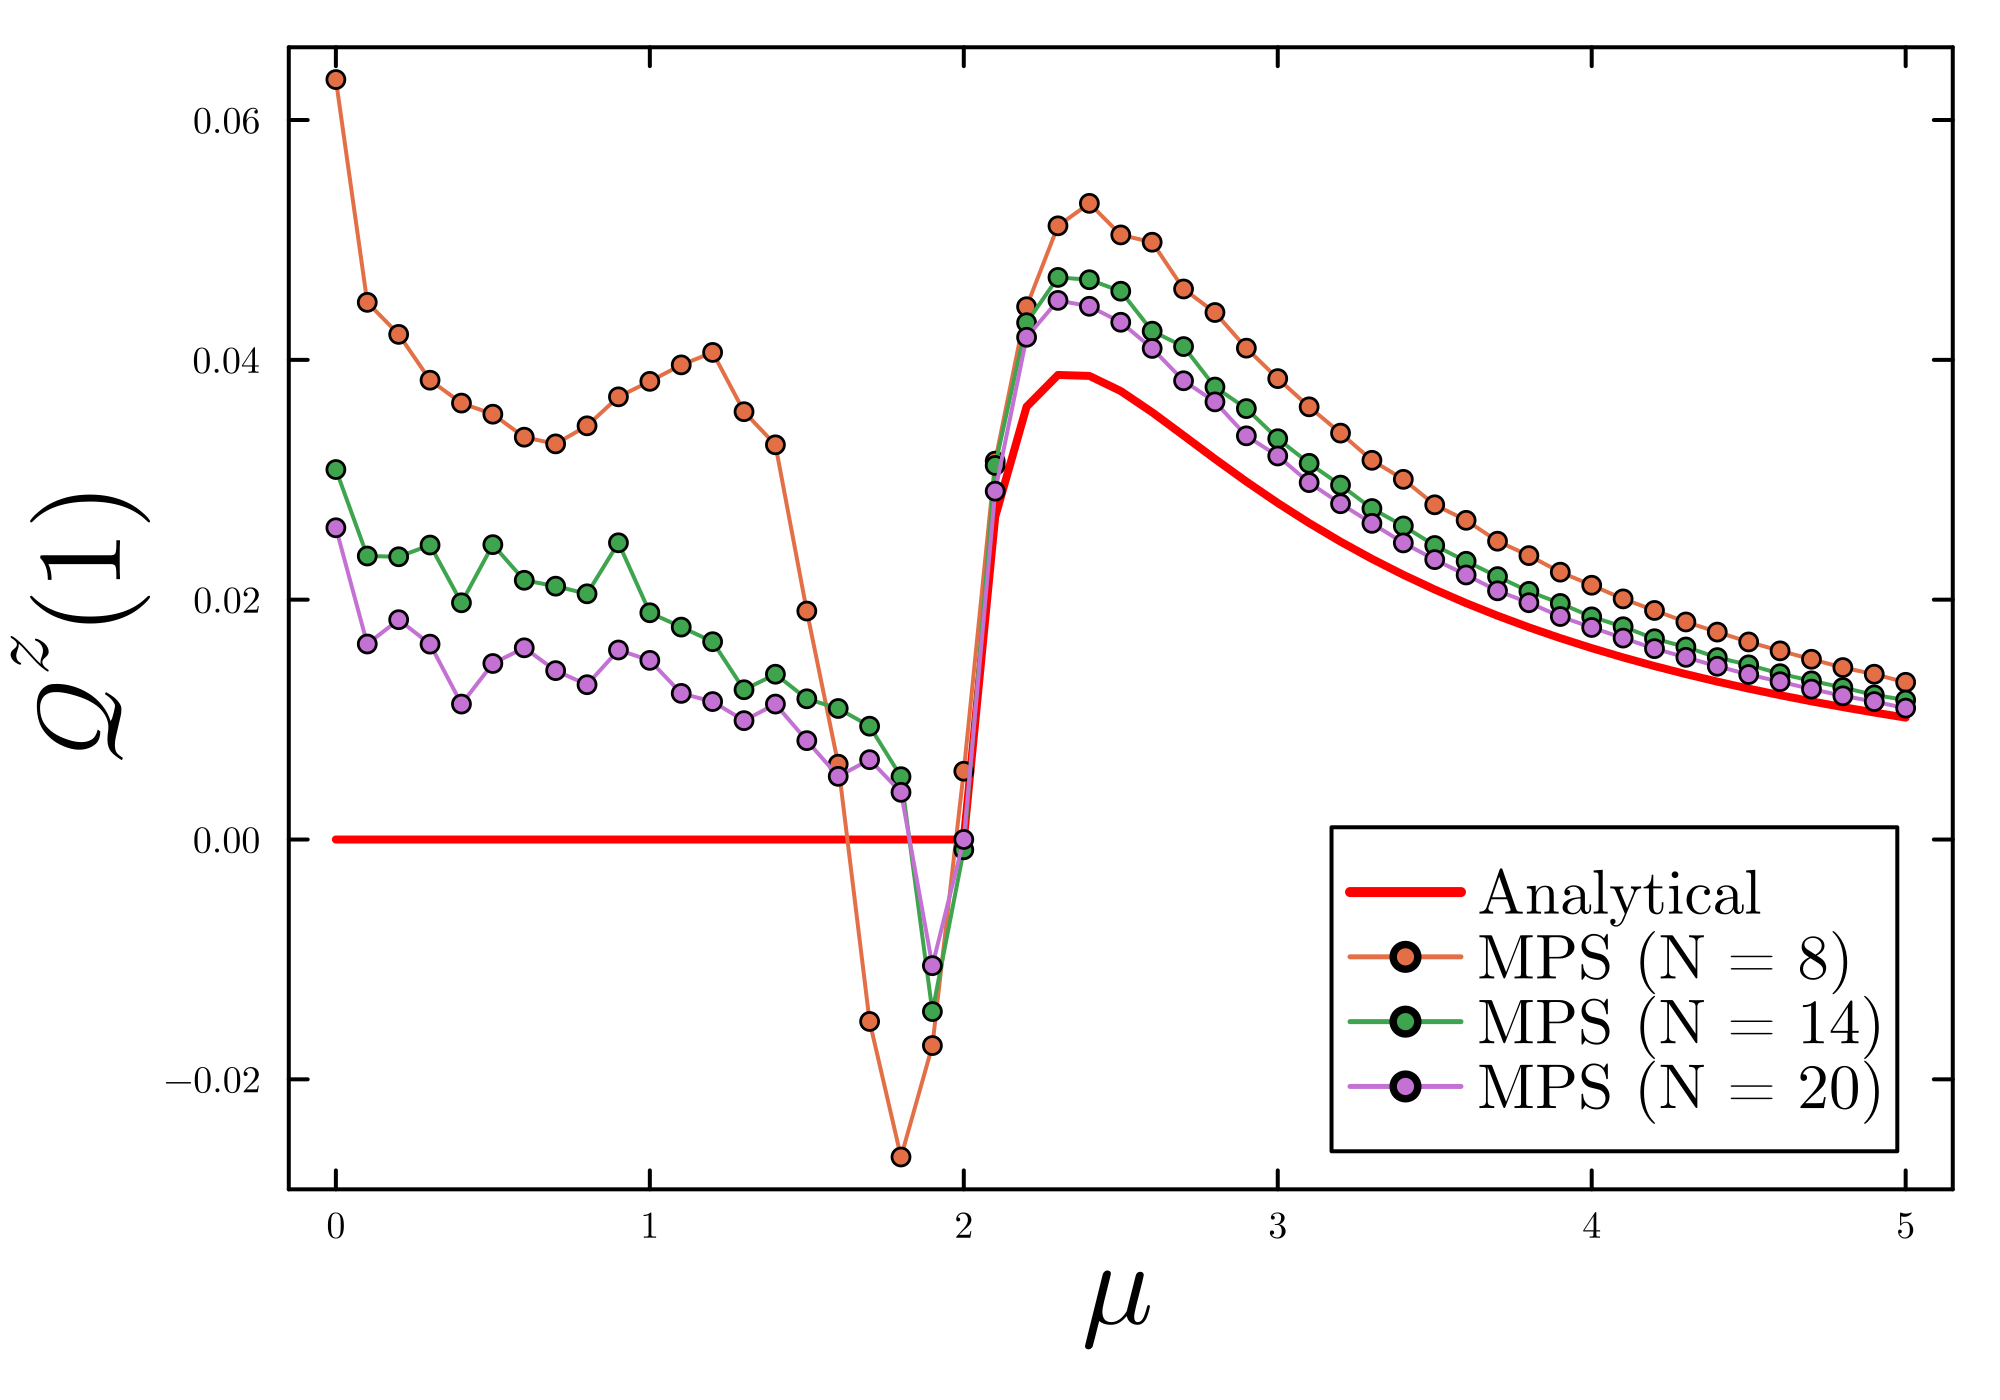

"c:\\Users\\khalafel\\OneDrive - Michigan State University\\Research\\OneDrive - Michigan State University\\Research\\Tensor network project\\Sz_different_N.png"

In [7]:
# Plot analytical line (red, thick)
xlabel_val = L"\mu"
ylabel_val = L"\mathcal{Q}^z(1)"

p = plot(
    mu_array,
    sz_corr2_anal,
    label = "Analytical",
    line = (:solid, 2, :red),
    xlabel = xlabel_val,
    ylabel = ylabel_val,
    legend = :bottomright, # Changed legend position
    grid = false,
    framestyle = :box,
    tickfontsize = 6,
    labelfontsize = 20, # Increased axis title size
    legendfontsize = 10,
    size = (500,350), # Made the plot smaller
    dpi = 400,
    fontfamily = "Computer Modern",
)

index_list = [1,4,6] # Index for the first N value

for i in index_list
    plot!(
        p,
        mu_array,
        Sz_correlation2[i, :],
        marker = (:circle, 2.5),
        label = "MPS (N = $(Nlist[i]))",
    )
end

# Display and save the plot
display(p)
savefig(p, "Sz_different_N.png")

In [8]:
Sz_corr2_diff = zeros(num_N, num_mu)

# Compute the difference between numerical and analytical results for each N
for n_idx in 1:num_N
    Sz_corr2_diff[n_idx, :] = abs.(Sz_correlation2[n_idx, :] .- sz_corr2_anal)
end
# Compute the mean value of each row and store as a 1D array
Sz_corr2_diff_integrated = [mean(Sz_corr2_diff[n_idx, :]) for n_idx in 1:num_N]


6-element Vector{Float64}:
 0.01762060390713383
 0.012993298647437973
 0.011206358608098481
 0.009615534211655424
 0.00809241032870478
 0.006678923280879993

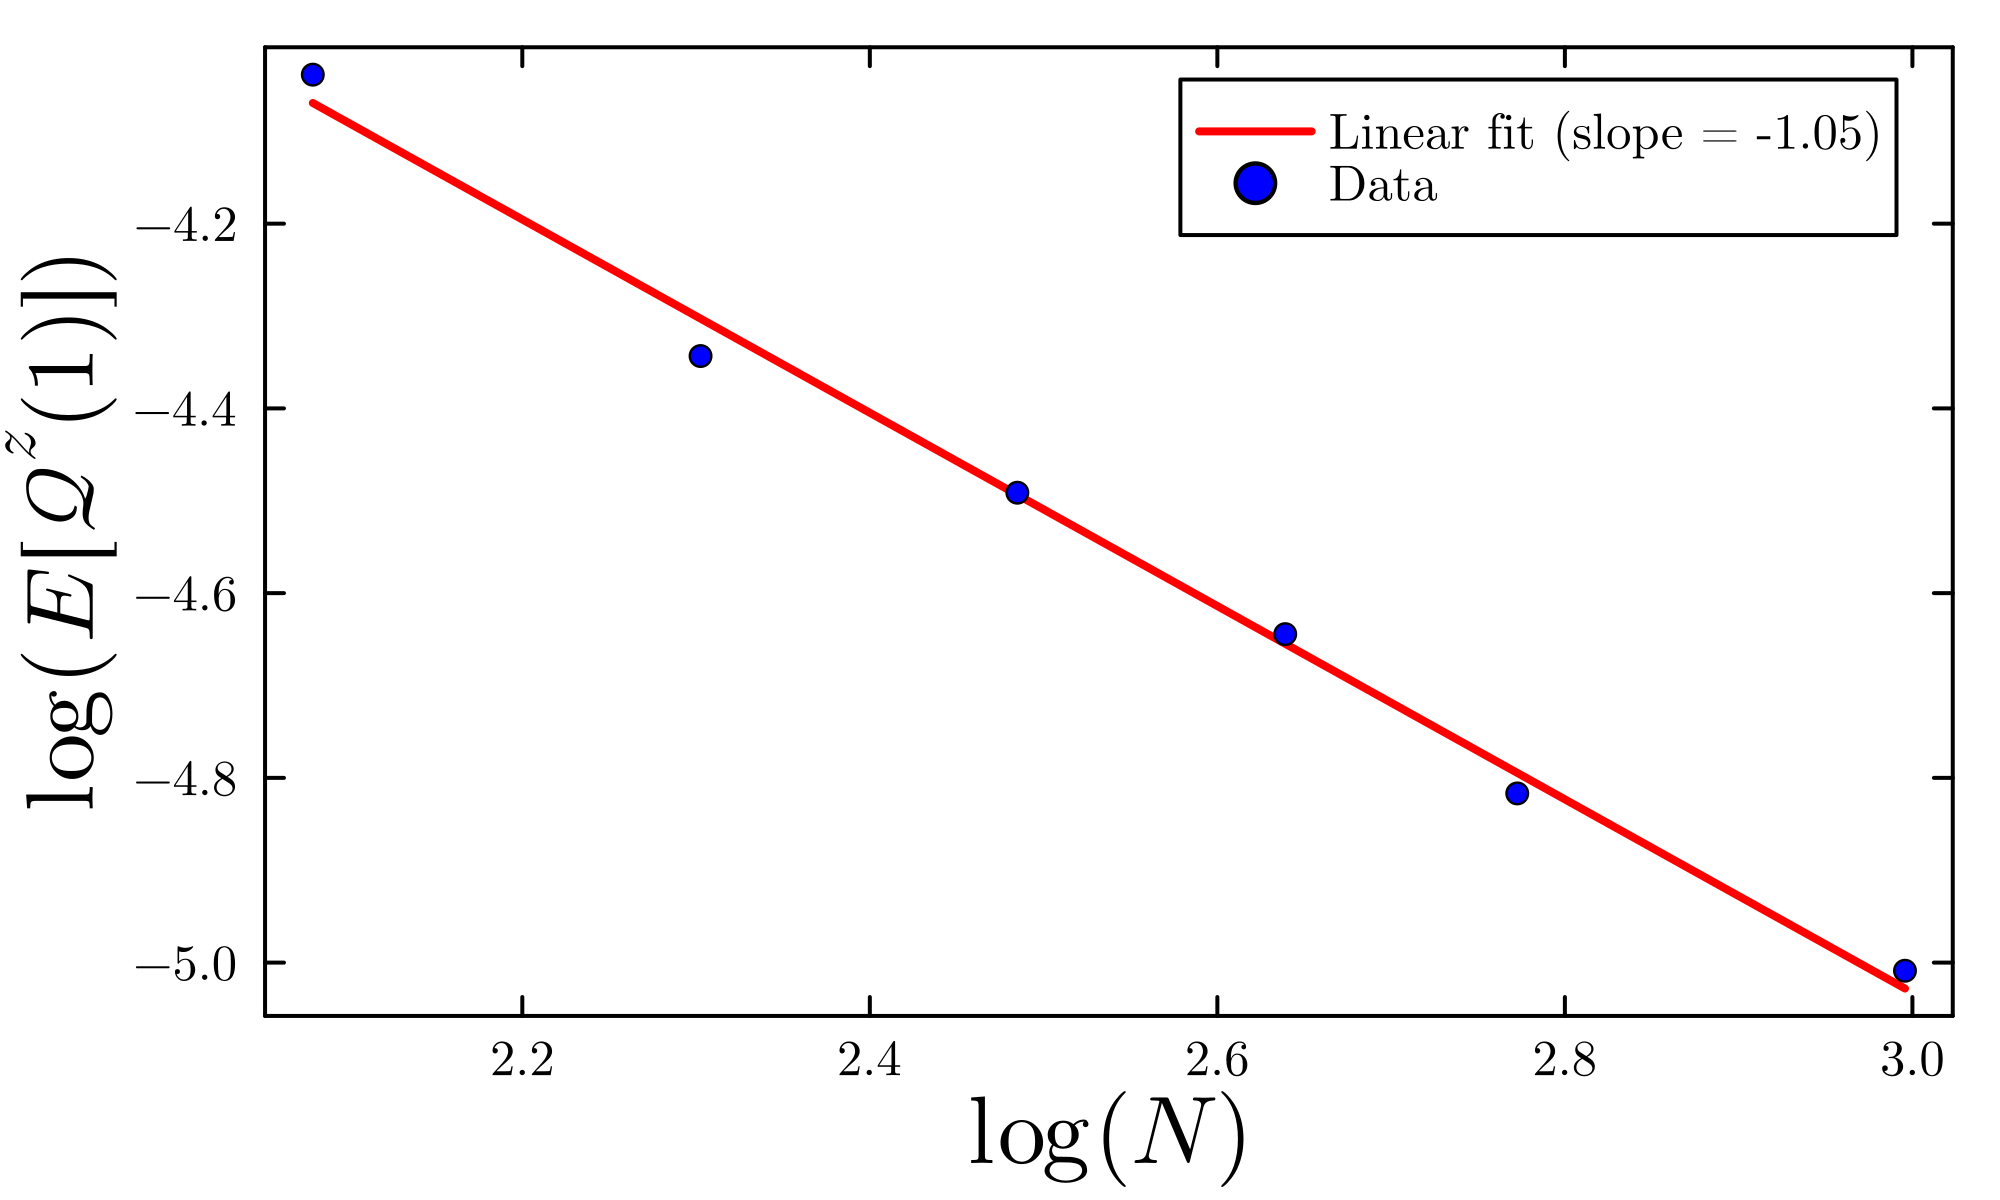

Slope of the best linear fit: -1.046276849661176


"c:\\Users\\khalafel\\OneDrive - Michigan State University\\Research\\OneDrive - Michigan State University\\Research\\Tensor network project\\loglog_sz_corr2_diff_vs_N.png"

In [9]:
# Prepare x and y data for the plot
log_N = log.(Nlist)  # log(N) for each N in Nlist
log_diff = log.(abs.(Sz_corr2_diff_integrated))  # log of absolute mean difference

# Perform a linear fit (least squares) to the log-log data
X = [ones(length(log_N)) log_N]  # Design matrix for linear fit (intercept + slope)
coeffs = X \ log_diff
intercept, slope = coeffs

# Generate fit line for plotting
log_N_fit = range(minimum(log_N), maximum(log_N), length=100)
fit_line = intercept .+ slope .* log_N_fit

# Plot log-log data and the linear fit
plot(
    log_N_fit,
    fit_line,
    label = "Linear fit (slope = $(round(slope, sigdigits=3)))",
    linewidth = 2,
    color = :red,
)
plot!(
    log_N,
    log_diff,
    seriestype = :scatter,
    marker = (:circle, 3),
    xlabel = L"\log(N)",
    ylabel = L"\log({E[\mathcal{Q}^z(1)]})",
    label = "Data",
    legend = :topright,
    grid = false,
    framestyle = :box,
    tickfontsize = 8,
    labelfontsize = 16,
    legendfontsize = 8,
    size = (500, 300),
    dpi = 400,
    color = :blue,
    fontfamily = "Computer Modern",
)


display(current())
println("Slope of the best linear fit: ", slope)

savefig("loglog_sz_corr2_diff_vs_N.png")